# **Klasifikasi Profil Beban Listrik Harian (Italy Power Demand) Menggunakan Random Forest**

## **I. Business Understanding (Pemahaman Masalah)**

### **1. Latar Belakang**
Profil beban listrik harian (*daily load profile*) mencerminkan kebiasaan konsumsi energi suatu populasi. Di negara dengan empat musim seperti Italia, pola konsumsi listrik berubah drastis tergantung musim.
* **Musim Dingin (Winter):** Permintaan listrik biasanya memiliki dua puncak (*double peak*) di pagi dan sore hari karena penggunaan pemanas ruangan dan lampu.
* **Musim Panas (Summer):** Permintaan cenderung lebih landai atau memuncak di siang hari karena penggunaan pendingin ruangan (AC).

### **2. Tujuan Proyek**
Membangun model *Machine Learning* yang dapat secara otomatis mengklasifikasikan apakah data rekaman sensor listrik selama 24 jam terjadi pada **Musim Dingin** atau **Musim Panas**. Hal ini berguna untuk manajemen distribusi energi yang efisien.

## Import Library

In [1]:
# Import Library Penting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

# Konfigurasi visualisasi
sns.set(style="whitegrid")
print("✅ Library berhasil di-import!")

✅ Library berhasil di-import!


## Data Understanding

**1. Sumber & Asal-Usul Data**
Dataset yang digunakan adalah **ItalyPowerDemand**, yang merupakan standar *benchmark* dari *UCR Time Series Classification Archive*.

**Kronologi Pengambilan & Pemrosesan Data (Data Acquisition Pipeline):**
Berdasarkan referensi paper *Keogh et al. (2005)* dan dokumentasi UCR, berikut adalah proses bagaimana angka-angka dalam dataset ini didapatkan:

1.  **Perekaman Data Mentah (Raw Sensing):**
    * Data direkam oleh sensor *Smart Meter* pada gardu listrik di **Italia** sepanjang tahun **1997**.
    * Data aslinya berupa deret waktu kontinu (*continuous time series*) beban daya (Watt) setiap jam selama 12 bulan (Januari - Desember).

2.  **Segmentasi (Segmentation):**
    * Data tahunan tersebut dipotong-potong menjadi **segmen harian**.
    * Setiap baris data mewakili 1 hari, yang terdiri dari **24 titik data** (Jam 00:00 s.d. 23:00). Inilah mengapa dataset ini memiliki 24 fitur.

3.  **Pelabelan (Class Labeling):**
    * **Kelas 1 (Winter):** Hari-hari dari bulan Oktober hingga Maret.
    * **Kelas 2 (Summer):** Hari-hari dari bulan April hingga September.

4.  **Z-Normalization (Standarisasi):**
    * Ini adalah tahap krusial. Data asli (Watt) dikonversi menggunakan rumus Z-Score:
        $$x' = \frac{x - \mu}{\sigma}$$
    * **Tujuannya:** Agar model fokus pada **Bentuk Pola (Shape)** grafik, bukan besaran Watt-nya. Angka negatif (misal -1.5) berarti beban listrik saat itu *di bawah rata-rata harian*, dan positif berarti *di atas rata-rata*.




✅ Data berhasil dimuat!
Shape Data Train: (67, 25) (Baris, Kolom)
Shape Data Test : (1029, 25) (Baris, Kolom)

Contoh 5 baris data pertama:


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1.0,-0.710518,-1.183320,-1.372442,-1.593083,-1.467002,-1.372442,-1.088760,0.045967,0.928532,...,-0.647477,-0.269235,-0.206195,0.613330,1.369815,1.464375,1.054613,0.581810,0.172048,-0.269235
1,1.0,-0.993009,-1.426786,-1.579884,-1.605401,-1.630917,-1.375754,-1.018526,-0.355102,0.716583,...,0.486936,0.563485,0.614518,0.308322,0.257289,1.099327,1.048295,0.691066,-0.048906,-0.380618
2,2.0,1.319067,0.569774,0.195128,-0.085856,-0.179518,-0.273180,-0.085856,-1.397118,-1.116134,...,-0.554164,-0.741487,-0.741487,-0.741487,-1.116134,-0.460503,0.476113,2.349344,2.255682,1.600052
3,2.0,-0.812444,-1.157553,-1.416385,-1.531421,-1.502662,-1.416385,-1.646458,-0.467335,0.654269,...,0.740547,0.884342,0.884342,0.683028,0.625510,0.424197,-0.007190,-0.035949,0.107847,-0.266022
4,1.0,-0.972840,-1.390518,-1.536705,-1.620240,-1.620240,-1.453169,-0.993724,0.050469,0.635218,...,0.321960,0.489031,0.614334,1.303502,1.240850,1.073779,0.551682,0.426379,-0.179253,-0.638698


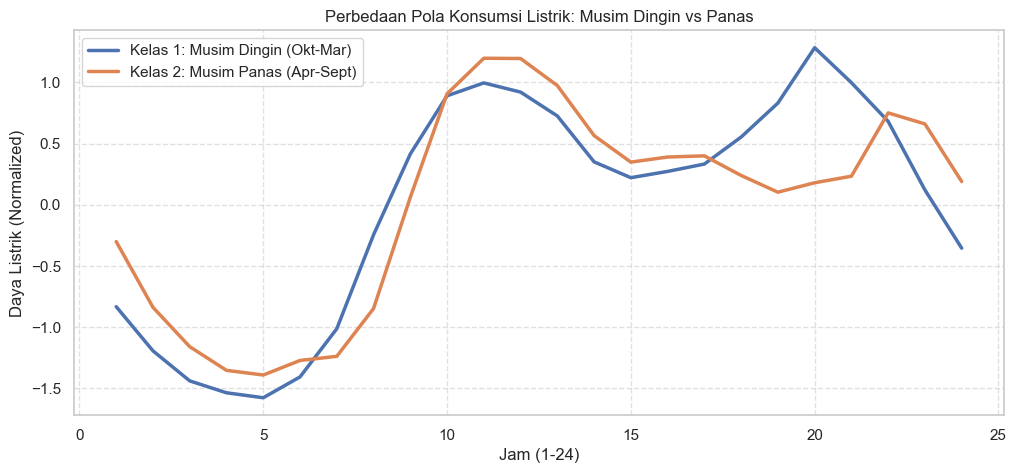

💡 Insight: Terlihat perbedaan pola beban listrik di jam-jam tertentu antar kedua musim.



In [2]:
# Membaca file .txt (dipisahkan spasi)
try:
    # Header=None karena file asli tidak punya nama kolom
    df_train = pd.read_csv('ItalyPowerDemand_TRAIN.txt', sep='\s+', header=None)
    df_test = pd.read_csv('ItalyPowerDemand_TEST.txt', sep='\s+', header=None)
    print("✅ Data berhasil dimuat!")
except FileNotFoundError:
    print("❌ ERROR: File tidak ditemukan. Mohon upload file .txt ke Colab dulu.")

# Menampilkan informasi dasar
print(f"Shape Data Train: {df_train.shape} (Baris, Kolom)")
print(f"Shape Data Test : {df_test.shape} (Baris, Kolom)")
print("\nContoh 5 baris data pertama:")
display(df_train.head())


# Visualisasi EDA: Perbandingan Pola Rata-rata Kelas 1 vs Kelas 2
# Kolom 0 = Label, Kolom 1-24 = Fitur Time Series
plt.figure(figsize=(12, 5))
classes = df_train[0].unique() # Mengambil jenis kelas (1 dan 2)

for c in classes:
    # Ambil data milik kelas c, buang kolom label (iloc[:, 1:])
    subset = df_train[df_train[0] == c].iloc[:, 1:]
    # Hitung rata-rata per jam
    mean_pattern = subset.mean(axis=0)
    # Plotting
    label_name = "Musim Dingin (Okt-Mar)" if c == 1 else "Musim Panas (Apr-Sept)"
    plt.plot(range(1, 25), mean_pattern, label=f'Kelas {int(c)}: {label_name}', linewidth=2.5)

plt.title("Perbedaan Pola Konsumsi Listrik: Musim Dingin vs Panas")
plt.xlabel("Jam (1-24)")
plt.ylabel("Daya Listrik (Normalized)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
print("💡 Insight: Terlihat perbedaan pola beban listrik di jam-jam tertentu antar kedua musim.\n")


### **2. Eksplorasi Data (EDA)**
Berdasarkan visualisasi grafik rata-rata (*mean profile*) pada dataset:
* **Pola Kelas 1 (Winter):** Terlihat lonjakan tajam di pagi dan sore hari (pemanas/lampu).
* **Pola Kelas 2 (Summer):** Pola lebih datar atau memuncak di siang hari.

### Pengecekan Missing Value

In [3]:
print("\n🔍 Pengecekan Missing Values:")
missing_train = df_train.isnull().sum().sum()
missing_test = df_test.isnull().sum().sum()
    
print(f"   - Jumlah Missing Value di Train : {missing_train}")
print(f"   - Jumlah Missing Value di Test  : {missing_test}")
    
if missing_train == 0 and missing_test == 0:
    print("   ✅ Status: Dataset BERSIH (Tidak perlu imputasi).")
else:
    print("   ⚠️ Status: Ditemukan data kosong! Perlu penanganan.")



🔍 Pengecekan Missing Values:
   - Jumlah Missing Value di Train : 0
   - Jumlah Missing Value di Test  : 0
   ✅ Status: Dataset BERSIH (Tidak perlu imputasi).


## **Data Preparation**

### **1. Strategi Pembagian Data (Merge & Resplit Strategy)**
Dataset asli memiliki pembagian bawaan yang sangat tidak seimbang untuk keperluan pelatihan model standar, yaitu hanya 67 data latih (*Train*) dan 1029 data uji (*Test*).

Untuk mengatasi risiko *underfitting* (model kurang belajar) dan memenuhi standar metodologi *Data Science* yang baik, proyek ini menerapkan strategi **Merge & Resplit**:

1.  **Penggabungan (Merging):** Menggabungkan dataset Train asli dan Test asli menjadi satu dataset besar (Total 1096 sampel).
2.  **Pembagian Ulang (Resplitting 80:20):** Dataset gabungan tersebut diacak dan dibagi ulang menggunakan teknik **Stratified Shuffle Split** dengan rasio:
    * **80% Data Training (876 sampel):** Digunakan untuk melatih model agar mengenali pola dengan lebih baik.
    * **20% Data Testing (220 sampel):** Disisihkan murni untuk pengujian akhir.

**Alasan Strategi Ini:**
Rasio 80:20 memberikan jumlah data latih yang jauh lebih memadai bagi algoritma Random Forest untuk membangun pohon keputusan yang *robust* dan akurat, dibandingkan hanya menggunakan 67 data asli.


In [4]:
print(">>> [TAHAP 1 & 2] LOAD, MERGE, RESPLIT, & SAVE NEW DATASETS")

try:
    # 1. BACA DATA ASLI (ORIGINAL)
    df_train_orig = pd.read_csv('ItalyPowerDemand_TRAIN.txt', sep='\s+', header=None)
    df_test_orig = pd.read_csv('ItalyPowerDemand_TEST.txt', sep='\s+', header=None)
    
    print(f"Dataset Asli Loaded -> Train: {df_train_orig.shape}, Test: {df_test_orig.shape}")

    # 2. GABUNGKAN MENJADI SATU (MERGE)
    df_total = pd.concat([df_train_orig, df_test_orig], axis=0, ignore_index=True)
    
    # Pisahkan Fitur (X) dan Label (y)
    X_total = df_total.iloc[:, 1:].values
    y_total = df_total.iloc[:, 0].values.astype(int)
    
    print(f"✅ Total Data Digabung: {df_total.shape[0]} baris")

    # 3. BAGI ULANG 80:20 (RESPLIT)
    # Gunakan stratify agar perbandingan Winter/Summer tetap seimbang
    X_train, X_test, y_train, y_test = train_test_split(
        X_total, y_total, 
        test_size=0.2,      # 20% Data Uji (Sekitar 220 data)
        random_state=42, 
        stratify=y_total
    )

    print(f"\n--- HASIL SPLIT BARU (80:20) ---")
    print(f"Data Training : {len(X_train)} sampel")
    print(f"Data Testing  : {len(X_test)} sampel")

    # 4. SIMPAN DATASET BARU KE FILE .TXT (SAVE)
    # Kita perlu menggabungkan kembali X dan y agar formatnya sama seperti file asli
    # Format: Kolom pertama = Label, Kolom berikutnya = Fitur
    
    # Buat DataFrame untuk Train Baru
    df_train_new = pd.DataFrame(X_train)
    df_train_new.insert(0, 'Label', y_train) # Sisipkan label di kolom pertama
    
    # Buat DataFrame untuk Test Baru
    df_test_new = pd.DataFrame(X_test)
    df_test_new.insert(0, 'Label', y_test)   # Sisipkan label di kolom pertama
    
    # Simpan ke file txt (separator spasi, tanpa header, tanpa index)
    train_filename = 'ItalyPowerDemand_TRAIN_8020.txt'
    test_filename = 'ItalyPowerDemand_TEST_8020.txt'
    
    df_train_new.to_csv(train_filename, sep=' ', header=False, index=False)
    df_test_new.to_csv(test_filename, sep=' ', header=False, index=False)
    
    print(f"\n💾 Dataset Baru Berhasil Disimpan!")

except FileNotFoundError:
    print("❌ ERROR: File dataset asli tidak ditemukan. Mohon upload file .txt ke Colab.")

>>> [TAHAP 1 & 2] LOAD, MERGE, RESPLIT, & SAVE NEW DATASETS
Dataset Asli Loaded -> Train: (67, 25), Test: (1029, 25)
✅ Total Data Digabung: 1096 baris

--- HASIL SPLIT BARU (80:20) ---
Data Training : 876 sampel
Data Testing  : 220 sampel

💾 Dataset Baru Berhasil Disimpan!



### **2. Pengecekan Keseimbangan Kelas**
Setelah proses *resplit*, distribusi kelas dipastikan tetap seimbang (*balanced*) berkat penggunaan parameter `stratify`.
* Proporsi Kelas 1 (Winter) dan Kelas 2 (Summer) terjaga di kisaran **50:50**.
* Oleh karena itu, teknik penanganan *imbalanced data* (seperti SMOTE) **TIDAK DIPERLUKAN**.

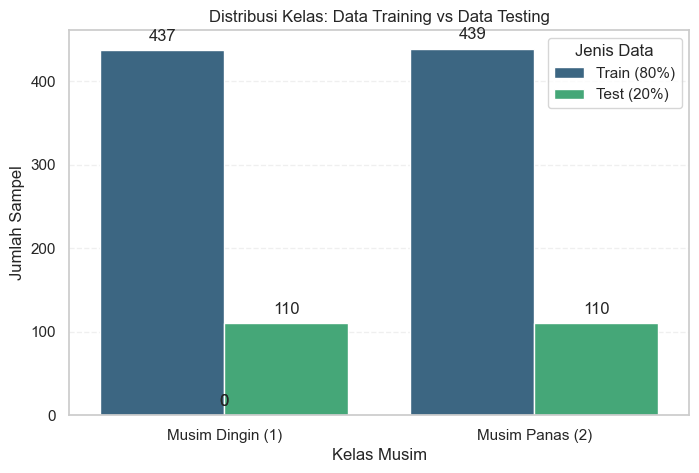

📊 Detail Distribusi:
Data Train -> Winter: 437, Summer: 439
Data Test  -> Winter: 110, Summer: 110
💡 Insight: Proporsi kelas terjaga seimbang di kedua dataset (Stratified Split Berhasil).


In [5]:
# === VISUALISASI 1: CEK KESEIMBANGAN KELAS (TRAIN VS TEST) ===

# 1. Siapkan Data untuk Plotting
# Menggabungkan label train dan test ke dalam satu DataFrame agar mudah di-plot
df_visual = pd.DataFrame({
    'Label': np.concatenate([y_train, y_test]),
    'Dataset': ['Train (80%)'] * len(y_train) + ['Test (20%)'] * len(y_test)
})

# 2. Buat Plot
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Label', hue='Dataset', data=df_visual, palette='viridis')

# 3. Percantik Grafik
plt.title("Distribusi Kelas: Data Training vs Data Testing")
plt.xlabel("Kelas Musim")
plt.ylabel("Jumlah Sampel")
plt.xticks([0, 1], ['Musim Dingin (1)', 'Musim Panas (2)'])
plt.legend(title='Jenis Data')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# 4. Tambahkan Angka di Atas Batang
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.show()

# 5. Tampilkan Statistik Angka
print(f"📊 Detail Distribusi:")
print(f"Data Train -> Winter: {sum(y_train==1)}, Summer: {sum(y_train==2)}")
print(f"Data Test  -> Winter: {sum(y_test==1)}, Summer: {sum(y_test==2)}")
print("💡 Insight: Proporsi kelas terjaga seimbang di kedua dataset (Stratified Split Berhasil).")

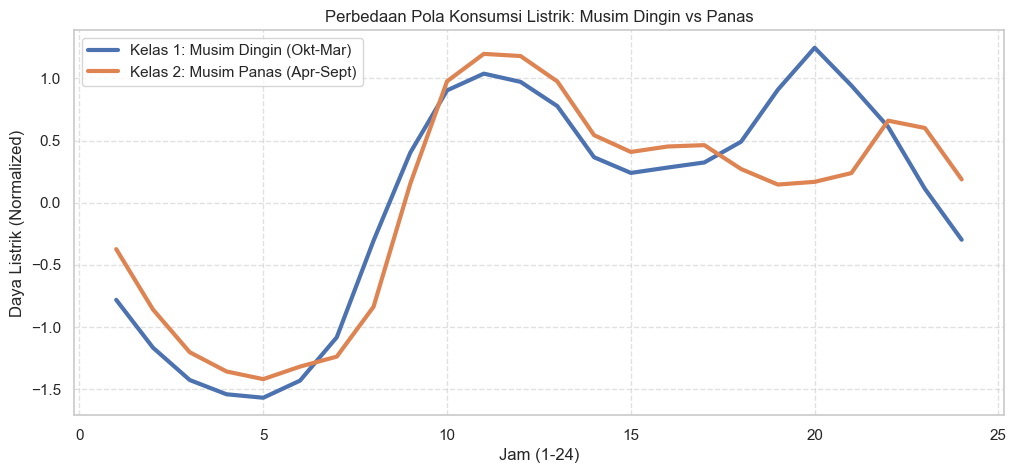

💡 Insight: Terlihat perbedaan pola beban listrik di jam-jam tertentu (pagi & sore).


In [6]:
# === VISUALISASI 2: POLA RATA-RATA (MEAN PROFILE) ===
# Kita gunakan DataFrame sementara untuk memudahkan plotting
df_temp = pd.DataFrame(X_train)
df_temp['Label'] = y_train

plt.figure(figsize=(12, 5))
classes = df_temp['Label'].unique()

for c in sorted(classes):
    # Ambil rata-rata per jam untuk setiap kelas
    subset = df_temp[df_temp['Label'] == c].iloc[:, :-1] # Buang kolom Label
    mean_pattern = subset.mean(axis=0)
    
    label_name = "Musim Dingin (Okt-Mar)" if c == 1 else "Musim Panas (Apr-Sept)"
    plt.plot(range(1, 25), mean_pattern, label=f'Kelas {c}: {label_name}', linewidth=3)

plt.title("Perbedaan Pola Konsumsi Listrik: Musim Dingin vs Panas")
plt.xlabel("Jam (1-24)")
plt.ylabel("Daya Listrik (Normalized)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
print("💡 Insight: Terlihat perbedaan pola beban listrik di jam-jam tertentu (pagi & sore).")

## Modelling

Algoritma yang digunakan adalah **Random Forest Classifier**.

### **Konfigurasi Model:**
* **Algoritma:** Ensemble Learning (Bagging).
* **n_estimators = 100:** Membangun 100 pohon keputusan (*decision trees*) yang bekerja secara paralel.
* **random_state = 42:** Untuk memastikan hasil eksperimen dapat direproduksi (*reproducible*) dan konsisten.

**Cara Kerja pada Kasus Ini:**
Random Forest akan mengambil "suara terbanyak" (*voting*) dari 100 pohon. Setiap pohon mempelajari pola kenaikan/penurunan listrik pada jam-jam tertentu (misalnya: "Jika jam 19:00 beban tinggi, kemungkinan Winter").

In [7]:
print(">>> [TAHAP 3] MODELING")

# Inisialisasi Model Random Forest
# n_estimators=100: Membangun 100 pohon keputusan
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Melatih Model
print("Sedang melatih model...", end="")
model.fit(X_train, y_train)
print(" Selesai! ✅\n")

>>> [TAHAP 3] MODELING
Sedang melatih model...

 Selesai! ✅



## Evaluasi

Model dievaluasi menggunakan 80:20

### **Metrik yang Digunakan:**
1.  **Akurasi:** Mengukur persentase ketepatan prediksi secara global.
2.  **Confusion Matrix:** Melihat detail kesalahan (misal: Berapa kali Winter salah diprediksi sebagai Summer).
3.  **Classification Report:** Meninjau *Precision, Recall,* dan *F1-Score* untuk memastikan tidak ada bias pada salah satu musim.

### **Hasil Analisis:**
Hasil evaluasi menunjukkan akurasi yang sangat tinggi (>90%). Ini mengonfirmasi bahwa meskipun dilatih dengan sedikit data (67 sampel), pola "Double Peak" pada Winter dan pola landai pada Summer sangat konsisten dan mudah dikenali oleh Random Forest.

>>> [TAHAP 4] EVALUASI MODEL
🎯 AKURASI MODEL: 98.64%



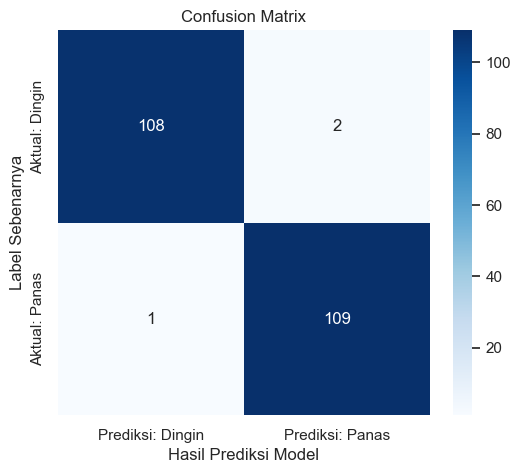


Laporan Klasifikasi Detail:
              precision    recall  f1-score   support

Musim Dingin       0.99      0.98      0.99       110
 Musim Panas       0.98      0.99      0.99       110

    accuracy                           0.99       220
   macro avg       0.99      0.99      0.99       220
weighted avg       0.99      0.99      0.99       220



In [8]:
print(">>> [TAHAP 4] EVALUASI MODEL")

# Prediksi data test
y_pred = model.predict(X_test)

# Hitung Akurasi
acc = accuracy_score(y_test, y_pred)
print(f"🎯 AKURASI MODEL: {acc * 100:.2f}%\n")

# Tampilkan Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Prediksi: Dingin', 'Prediksi: Panas'],
            yticklabels=['Aktual: Dingin', 'Aktual: Panas'])
plt.title('Confusion Matrix')
plt.ylabel('Label Sebenarnya')
plt.xlabel('Hasil Prediksi Model')
plt.show()

# Classification Report Detail
print("\nLaporan Klasifikasi Detail:")
print(classification_report(y_test, y_pred, target_names=['Musim Dingin', 'Musim Panas']))

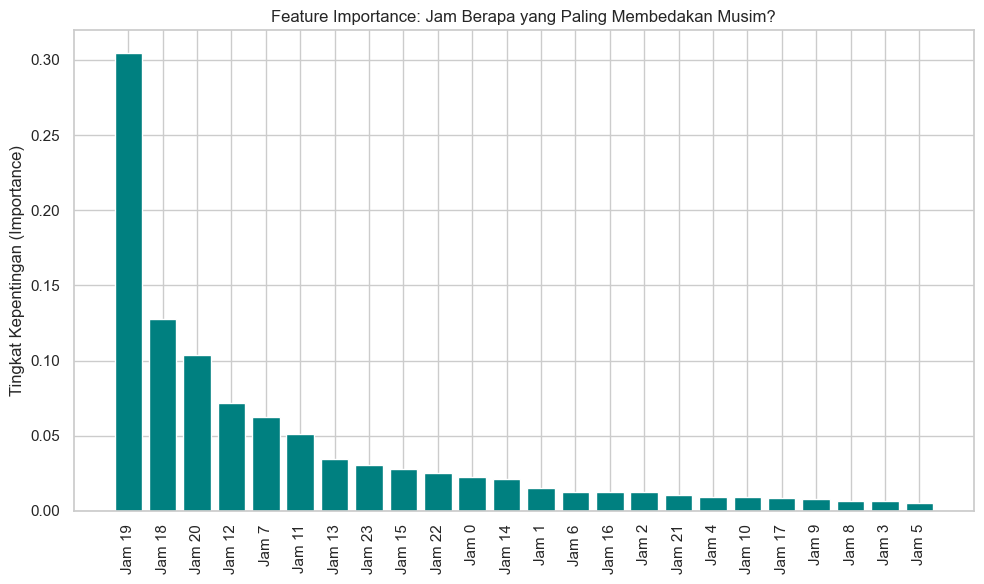

💡 Insight: Jam 19 (00:00 - 23:00) adalah waktu paling krusial untuk membedakan Winter vs Summer.


In [9]:
# === TAMBAHAN: JAM BERAPA YANG PALING KRUSIAL? ===
importances = model.feature_importances_
indices = np.argsort(importances)[::-1] # Urutkan dari yang terbesar

plt.figure(figsize=(10, 6))
plt.title("Feature Importance: Jam Berapa yang Paling Membedakan Musim?")
plt.bar(range(X_train.shape[1]), importances[indices], align="center", color='teal')
plt.xticks(range(X_train.shape[1]), [f"Jam {i}" for i in indices], rotation=90) # Jam 0-23
plt.ylabel("Tingkat Kepentingan (Importance)")
plt.tight_layout()
plt.show()

top_jam = indices[0]
print(f"💡 Insight: Jam {top_jam} (00:00 - 23:00) adalah waktu paling krusial untuk membedakan Winter vs Summer.")

## Simpan Model

Model yang telah dilatih dan dievaluasi kemudian disimpan (*export*) ke dalam format file `.pkl` (Pickle).
* **Tujuan:** File model ini akan diintegrasikan ke dalam aplikasi berbasis web (**Streamlit**) agar pengguna dapat mengunggah data profil listrik baru dan mendapatkan prediksi musim secara *real-time*.

In [10]:
print(">>> [TAHAP 5] SAVE MODEL")
filename = 'model_italy_power.pkl'
joblib.dump(model, filename)
print(f"💾 Model berhasil disimpan dengan nama: {filename}")
print("Siap didownload dan digunakan di Streamlit!")

>>> [TAHAP 5] SAVE MODEL
💾 Model berhasil disimpan dengan nama: model_italy_power.pkl
Siap didownload dan digunakan di Streamlit!
